Pressure force on a sphere is
\begin{equation}
    F_{\text{pr}} = - \frac{1}{2} p_0^2 \beta \cdot \sigma_{\text{pr}},
\end{equation}
where pressure cross section is given by
\begin{equation}
    \sigma_{\text{pr}} = \frac{4\pi}{k^2} \sum_{n=0}^{\infty} \bigg[ (2n+1) \Re \left(a_n\right) + 2(n+1) \Re\left( a_n^* a_{n+1} \right) \bigg]
\end{equation}

In [24]:
import numpy as np
import scipy.special as sp
import scipy.constants as const
from icecream import ic

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [5]:
def sphericalh1(n, z, p=0):
    if p:
        return np.sqrt(np.pi / (2*z)) * ((n / z) * sp.hankel1(n+0.5, z) - sp.hankel1(n+1.5, z))
    else:
        return np.sqrt(np.pi / (2*z)) * sp.hankel1(n+0.5, z)


def an_func(n, ka, rho_rel, beta_rel):
    """
        n - multipole order
        ka - size parameter
        rho_rel - relative density
        beta_rel - relative compressibility
    """
    gamma = np.sqrt(beta_rel/rho_rel)
    k1a = ka * np.sqrt(beta_rel*rho_rel)
    jn1 = sp.spherical_jn(n, k1a)
    jn = sp.spherical_jn(n, ka)
    jn1p = sp.spherical_jn(n, k1a, 1)
    jnp = sp.spherical_jn(n, ka, 1)
    hn = sphericalh1(n, ka)
    hnp = sphericalh1(n, ka, 1)
    up = (gamma * jn1p * jn - jn1 * jnp)
    down = (jn1 * hnp - gamma * jn1p * hn)
    
    ans = np.where(
        down == 0,
        0,
        up/down
    )
    return ans
    
    
def sigmaSc_func(k, a, rho_rel, beta_rel, nmin=0, nmax=50):
    ka = a * k
    
    sigma_sc = np.zeros(ka.size, dtype=np.float64)
    sigma_sc_n = np.zeros([nmax+1 - nmin, ka.size])
    
    for n in range(nmin, nmax+1):
        an = an_func(n, ka, rho_rel, beta_rel)
        sigma_sc_n[n, :] = 4*np.pi / k**2 * (2*n+1) * np.abs(an**2)
        
    sigma_sc = np.sum(sigma_sc_n, axis=0)
    
    return sigma_sc, sigma_sc_n


def sigma_pressure(k, a, rho_rel, beta_rel, nmin=0, nmax=50):
    ka = k*a
    sigma_pr = np.zeros(ka.size, dtype=np.float64)
    sigma_pr_n = np.zeros([nmax+1 - nmin, ka.size])
    for n in range(nmin, nmax+1):
        an = an_func(n, ka, rho_rel, beta_rel)
        an_plus1 = an_func(n+1, ka, rho_rel, beta_rel)
        sigma_pr_n[n, :] = 4*np.pi/k**2 * ( (2*n+1) * np.real(an) + 2*(n+1)*np.real(np.conj(an) * an_plus1) )
        
    sigma_pr = np.sum(sigma_pr_n, axis=0)
    
    return sigma_pr, sigma_pr_n

In [115]:
beta_rel = 2 + 0.2j
rho_rel = 3 + 0.3j

a = np.linspace(0.1, stop=3, num=300)

k_ref = 1
theta = np.pi/4

delta_k = np.linspace(0, stop=0.9, num=30)
gamma = np.zeros((delta_k.size, a.size))

for (i, dk) in enumerate(delta_k):
    k1 = k_ref - dk/2
    k2 = k_ref + dk/2
    
    sigma_pr1, _ = sigma_pressure(k1, a, rho_rel, beta_rel)
    sigma_pr2, _ = sigma_pressure(k2, a, rho_rel, beta_rel)
    
    F1, F2 = - sigma_pr1, - sigma_pr2
    gamma[i, :] = np.arctan(((F2 - F1) * np.sin(theta))/((F2 + F1) * np.cos(theta)))

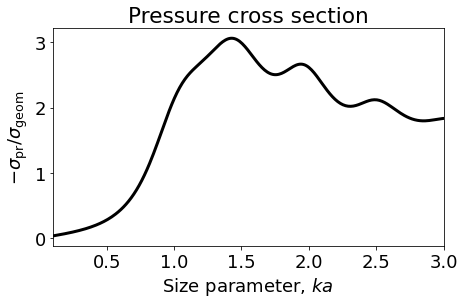

In [116]:
plt.figure(figsize=(7, 4))

sigma_pr, sigma_pr_n = sigma_pressure(k_ref, a, rho_rel, beta_rel)

sigma_geom = np.pi * a**2

plt.plot(k_ref*a, -sigma_pr/sigma_geom, lw=3, c='k')
plt.margins(x=0)
plt.title('Pressure cross section')
plt.ylabel('$-\sigma_{\mathrm{pr}}/\sigma_{\mathrm{geom}}$')
plt.xlabel('Size parameter, $ka$')
plt.show()

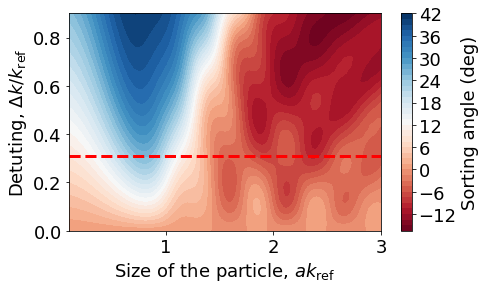

In [117]:
i_choice = 10

plt.figure(figsize=(7, 4))
plt.contourf(a*k_ref, delta_k/k_ref, gamma/np.pi*180, cmap='RdBu', levels=50)
plt.axhline(delta_k[i_choice]/k_ref, c='red', ls='--', lw=3)
plt.xlabel('Size of the particle, $a k_\mathrm{ref}$')
plt.ylabel('Detuting, $\Delta k/k_\mathrm{ref}$')
plt.colorbar(label='Sorting angle (deg)')
plt.show()

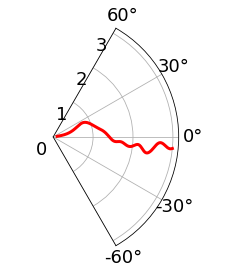

In [118]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
c = ax.plot(gamma[i_choice, :], a*k_ref, lw=3, c='red')

ax.set_thetamin(60)
ax.set_thetamax(-60)

plt.show()